# Planning

Business problem
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Problem type: Binary Classification
- The 'abandono_clientes.csv' dataset contains 10k rows and 13 features, which is enough to create a supervised machine learning model using a frequentist approach.
- To deal with this churn problem, some classification models will be created, and the best one will be used.

Evaluation metric: F1 score 
- F1 score will be the metric used with cross-validation, considering:
    - The business team needs a good balance between finding actual churners (recall) and avoiding false alarms (precision). 
    - The classes are unbalanced (20% of customers churned).

Methodology: CRISP-DM
- Cross Industry Standard Process for Data Mining methodology will be used, being cyclical and flexible, in order to take advantage of best market practices.

Restrictions:
- An initial project cycle will be developed, due to deadline reasons.

Project deliverables:
- EDA Notebook with:
    - Statistical analysis of data.
    - Business Insights from variables.
- Modeling Notebook with: 
    - Churn prediction model with a baseline > 0.55 (55%) on test data: 55% effectiveness in identifying true churners.
    - Model decisions explained, so retention team can understand predictions.
    - Business and Financial results of the project.
- CSV file with:
    - 'abandono_result.csv' file, being the model predictions from 'abandono_teste.csv' test dataset, with rowNumber and predictedValues columns.

# Imports

In [9]:
import pandas as pd
import numpy as np
import inflection
from scipy.stats import shapiro

import seaborn as sns
from matplotlib import pyplot as plt
import sweetviz as sv  #requires numpy downgrade (numpy==1.26.0)
# import shap

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

## Functions

In [10]:
###############################################################
#FUNCTIONS
def statistics(data):

    num_data = data.select_dtypes(include=['int', 'float'])

    # Central Tendency
    mean = num_data.apply(np.mean)
    q50 = num_data.quantile(0.5)

    # quantiles
    q25 = num_data.quantile(0.25)
    q50 = num_data.quantile(0.5)
    q75 = num_data.quantile(0.75)
    range_ = num_data.apply(lambda x: x.max() - x.min())
    count = num_data.count()

    # Dispersion
    min_ = num_data.apply(min)
    max_ = num_data.apply(max)
    std = num_data.apply(np.std)

    skew = num_data.apply(lambda x: x.skew())
    kurtosis = num_data.apply(lambda x: x.kurtosis())

    metrics = pd.DataFrame({'non-null': count, 'range': range_ ,'min': min_, 'quant25': q25, 'median':q50, 'quant75': q75,
                            'max':max_, 'median':q50, 'mean':mean, 'std':std,'skew':skew,'kurtosis':kurtosis})
    
    return (np.round(metrics,1))
    
###############################################################
#CLASSES

# Rename dataframe columns (snake_case) 
class RenameDfColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.copy().rename(columns=lambda x: inflection.underscore(x))


# Remove features from dataset
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns if columns else []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=self.columns)    

## Load Data

In [11]:
df_raw = pd.read_csv('../data/train/abandono_clientes.csv')
df_raw.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


## Data Split

In [12]:
train, test = train_test_split( df_raw, train_size=0.80, test_size=0.20, random_state=98, stratify=df_raw.Exited, shuffle=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# #will be used on final pipeline:
# X_train_raw = train.drop('Exited', axis = 1)
# y_train_raw = train.Exited 
# X_test_raw = test.drop('Exited', axis = 1) 
# y_test_raw = test.Exited 

print(f'Train Size: {len(train):} ({len(train)/len(df_raw):.1%})')
print(f'Test Size: {len(test):} ({len(test)/len(df_raw):.1%})')

Train Size: 8000 (80.0%)
Test Size: 2000 (20.0%)


## Data Dictionary

|  Column   | Meaning   |
| :-------  | :------- |
| **RowNumber** | Record number |
| **CustomerId** | Customer ID |
| **Surname** | Customer's last name |
| **CreditScore** | Customer's credit score |
| **Geography** | Customer's country of residence |
| **Gender** | Costumer's gender |
| **Age** | Costumer's age |
| **Tenure** | Number of years that the customer has been a client of the institution |
| **Balande** | Ammount of money the client have on it's account |
| **NumOfProducts** | Number of products that a customer has purchased through the institution |
| **HasCrCard** | Denotes whether or not a customer has a credit card with the institution. [1 - has credit card; 0 - dosen't have credit card] |
| **IsActiveMember** | Denotes whether client is active or not. [1 - active; 0 - non active ] |
| **EstimatedSalary** | Client's estimated anual salary |
| **Exited** | Denotes whether the client has an account at the institution. [1 - Client has exited instittion; 0 - client dosen't have exited institution] |

# Data Cleaning

## Rename Features

In [13]:
#Rename columns (snake_case) with Pipeline 
pipe_rename_features = Pipeline([
    ('rename_features', RenameDfColumns())
])
train = pipe_rename_features.fit_transform(train)
train.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0
1,4606,15585599,Stone,530,France,Female,34,8,0.00,2,0,1,141872.52,0


## DTypes and Missings

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        8000 non-null   int64  
 1   customer_id       8000 non-null   int64  
 2   surname           8000 non-null   object 
 3   credit_score      8000 non-null   int64  
 4   geography         8000 non-null   object 
 5   gender            8000 non-null   object 
 6   age               8000 non-null   int64  
 7   tenure            8000 non-null   int64  
 8   balance           8000 non-null   float64
 9   num_of_products   8000 non-null   int64  
 10  has_cr_card       8000 non-null   int64  
 11  is_active_member  8000 non-null   int64  
 12  estimated_salary  8000 non-null   float64
 13  exited            8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


No missings, dtypes ok.

## Duplicates

In [15]:
# Get duplicate rows
train[train.duplicated()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No duplicated rows.

## Feature Filtering

Remove unnecessary features:

In [16]:
# Remove features with Pipeline
pipe_filter_features = Pipeline([
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname']))
])

# Filter Columns using Pipeline
train = pipe_filter_features.transform(train)
train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0


# EDA

## Descriptive Statistics

### Univariate Analysis

Composed of:
- Location Metrics (central tendency), that show where the data is centered, such as mean and median.
- Variability Metrics (cispersion), that reveal how the values are spread around that center, such as standard deviation, quantiles, skewness and kurtosis.

Below, all the numerical variables in the dataset will be analyzed.

In [17]:
statistics(train)

,non-null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
credit_score,8000,500.0,350.0,583.0,652.0,716.0,850.0,649.9,96.7,-0.1,-0.4
age,8000,74.0,18.0,32.0,37.0,44.0,92.0,38.9,10.4,1.0,1.4
tenure,8000,10.0,0.0,2.0,5.0,7.0,10.0,5.0,2.9,0.0,-1.2
balance,8000,250898.1,0.0,0.0,97276.1,127743.6,250898.1,76673.7,62487.0,-0.1,-1.5
num_of_products,8000,3.0,1.0,1.0,1.0,2.0,4.0,1.5,0.6,0.8,0.6
has_cr_card,8000,1.0,0.0,0.0,1.0,1.0,1.0,0.7,0.5,-0.9,-1.2
is_active_member,8000,1.0,0.0,0.0,1.0,1.0,1.0,0.5,0.5,-0.1,-2.0
estimated_salary,8000,199902.4,90.1,51986.1,100487.7,149216.3,199992.5,100467.8,57274.2,-0.0,-1.2
exited,8000,1.0,0.0,0.0,0.0,0.0,1.0,0.2,0.4,1.5,0.2


Analysis:
- age: has positive kurtosis, so there is a peak arround the median.
- balance: quant25 shows 0.00, meaning at least 25% of data equals to zero. No negative values were found.
- num_of_products: max is 4, but median is 1, so at least 50% of customers have only 1 product.
- has_cr_card: negative skew shows that the concentration of values is high, so most customers have a credit card.
- estimated_salary: skew 0.00 shows that estimated salaries are not concentrated in low or high values, having an uniform distribuition.
- exited: positive skew shows that the concentration of values is low, with most values being zero, as expected for a churn problem.

### Bivariate and Multivariate Analysis

SweetViz was used to generate insights.

In [19]:
#Generate report
sv_report_df = sv.analyze(train, target_feat="exited") #
sv_report_df.show_html(filepath='../reports/sv_report.html',open_browser=False)

Done! Use 'show' commands to display/save.   |█████████████████████████████████████████| [100%]   00:00 -> (00:00 left)

Report ../reports/sv_report.html was generated.


The SweetViz report shows that:

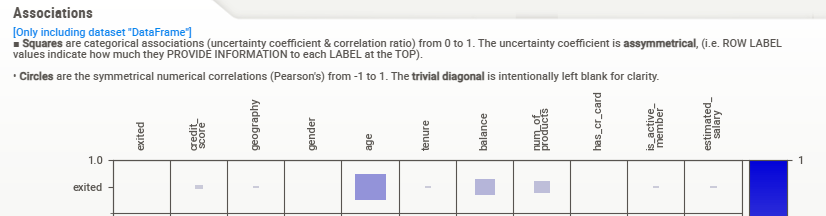
- churn (exited) -> is mostly associated categorically with: age, balance and num_of_products.

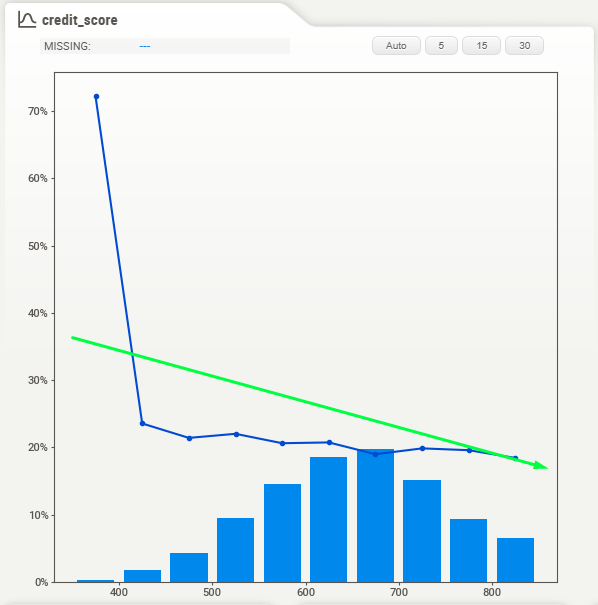
- Credit score -> as the customer's credit score increases, churn drops.

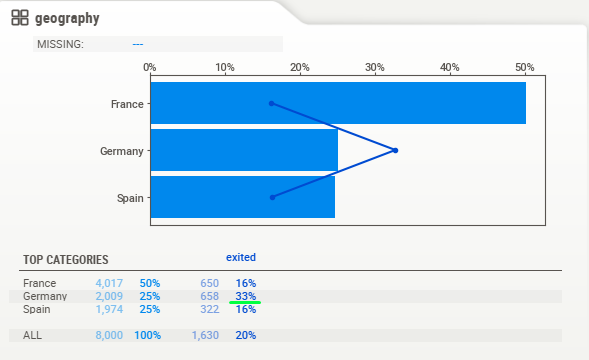
- geography -> Germany customers churn more: 33% of customers in Germany churned, vs 16% in France and Spain (less than half).

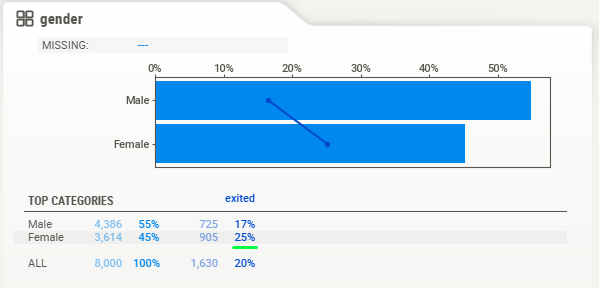
- gender -> female customers churn more: 25% of them churned, vs 17% of male.

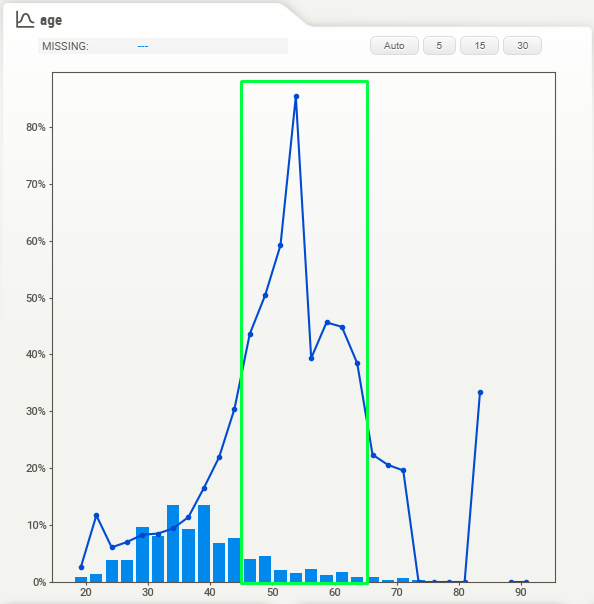
- age -> churn is concentrated mostly on customers with age between 45 and 65 years.

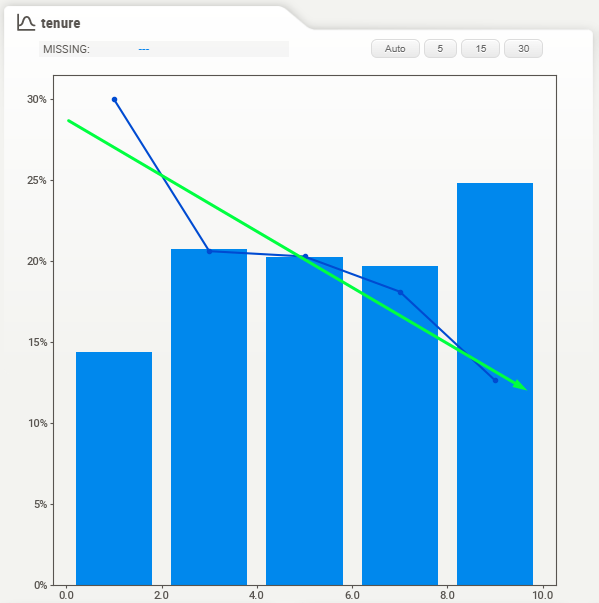
- Tenure -> order customers churn less: the older the customer, the less he churned.

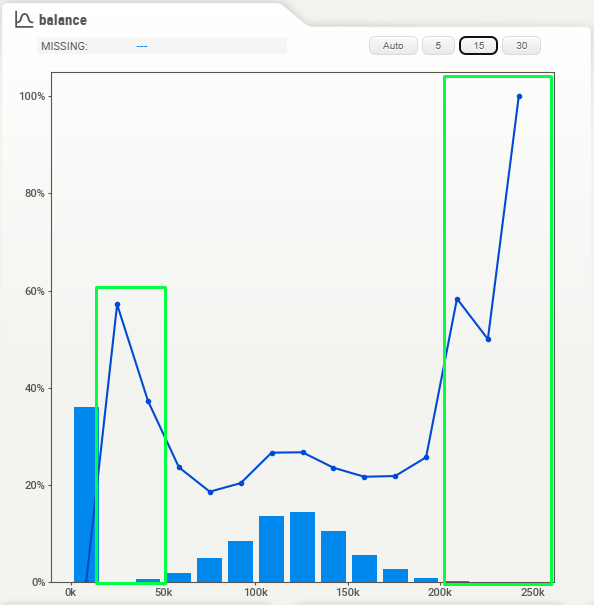
- balance -> customer on the tail of the distribuition churned more: except customers with a balance = 0, those with less than 50k and with more than 200k churned more.

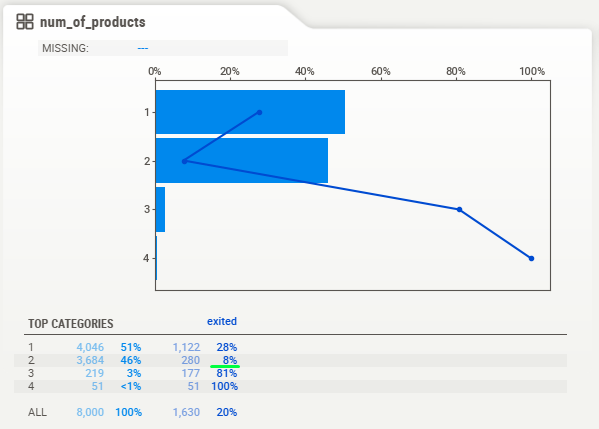
- num_of_products:
  - customers with 2 products churned less (8%).
  - customers with 1 product churned more (28%).
  - customers with 3 products churned even more (81%).
  - 100% of customers with 4 products churned.

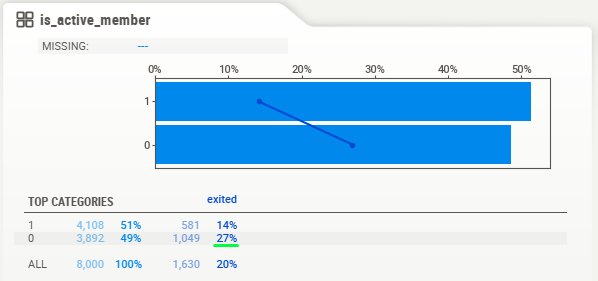
- is_active_member -> inactive members churn more: 27% of churn comes from inactive members, while 14% came from active members.

This insights may be shared with business team, as inputs for actions aimed at reducing churn.